# Project - Sales Forecasting Accuracy Increasing 

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [3]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


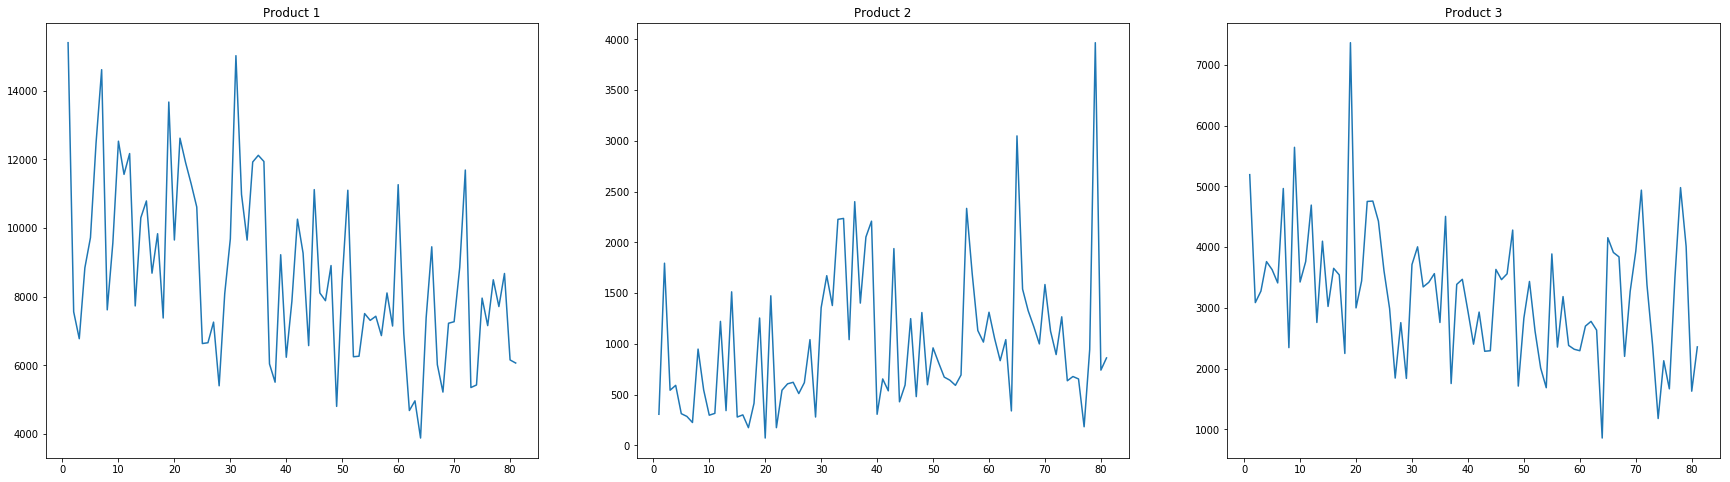

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

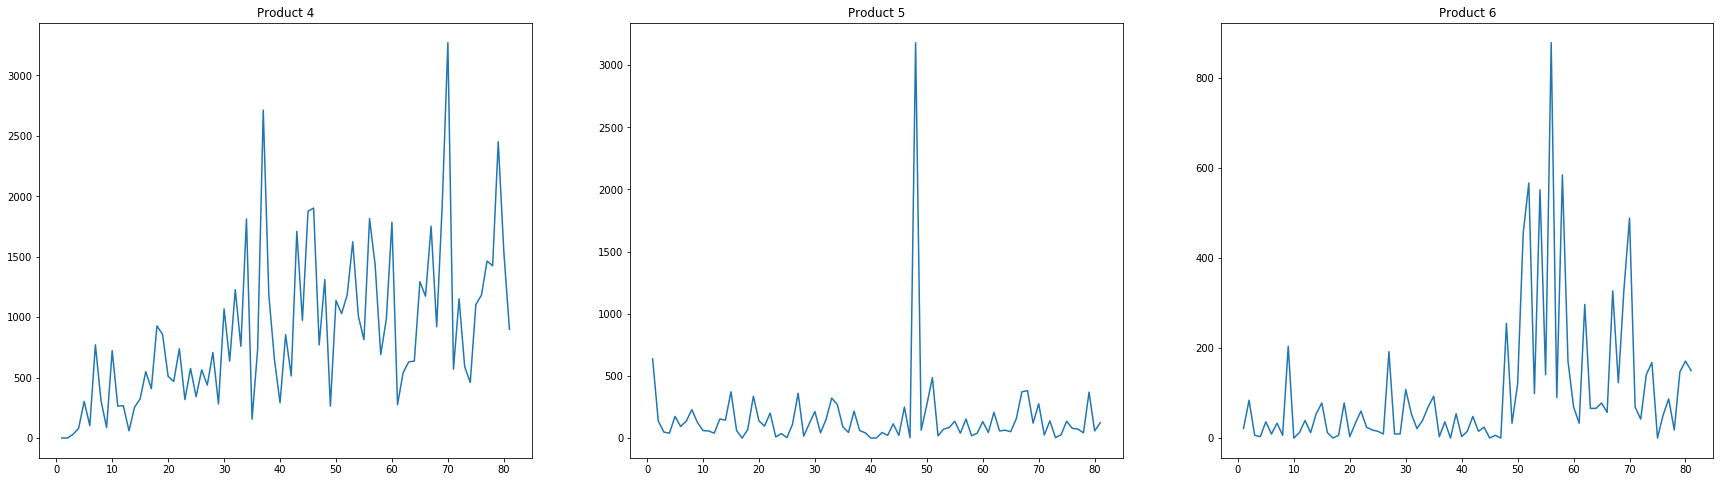

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

# ARIMA Product #2

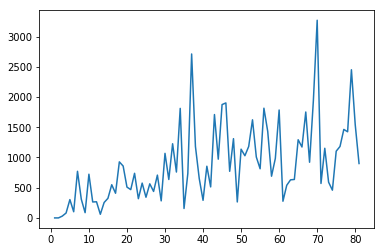

In [6]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 4"]);

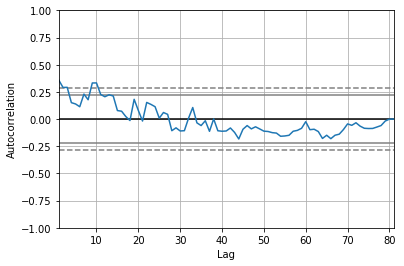

In [7]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 4"]);

count      81.000000
mean      881.888889
std       645.320754
min         0.000000
25%       408.000000
50%       738.000000
75%      1182.000000
max      3270.000000
Name: Actual 4, dtype: float64

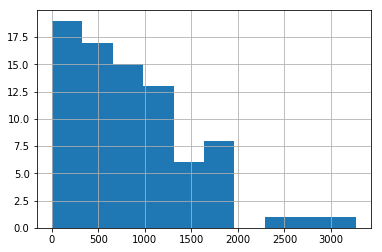

In [8]:
itog1 = data["Actual 4"].describe()
data["Actual 4"].hist()
itog1

Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет относительно 
большой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где 
        LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [9]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 0.731748


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [10]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 4"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

        JB                p-value               skew            kurtosis    
----------------------------------------------------------------------------
25.896415553100567 2.380481507780208e-06 1.140619510121646 4.571292636097085
----------------------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения
#отвергается с большой вероятностью (probably > 0.05), и, следовательно, наш ряд НЕ имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [11]:
test = sm.tsa.adfuller(data["Actual 4"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.156828649693962
p-value:  7.334115584600523e-08
Critical values:  {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [12]:
ts1 = data["Actual 4"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [13]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.999842070134828
p-value:  1.667487067385089e-07
Critical values:  {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [14]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.7064958683440061


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

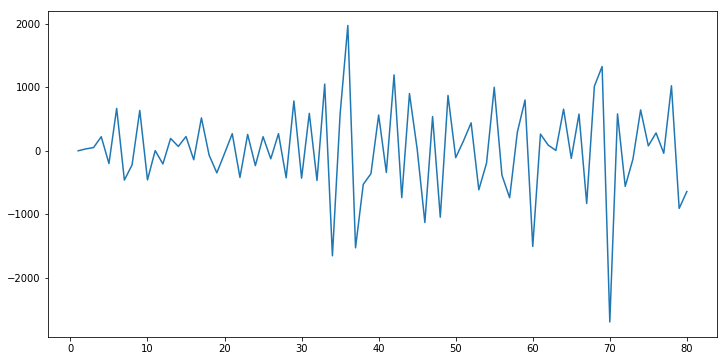

In [15]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

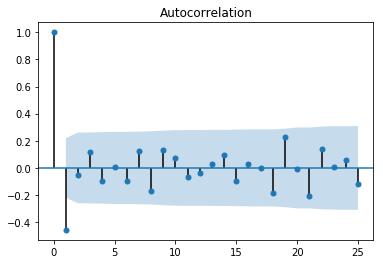

In [16]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

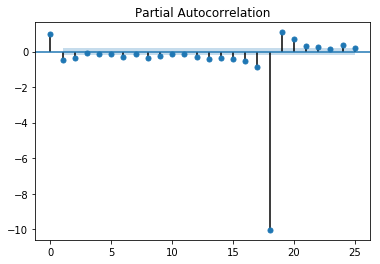

In [17]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [18]:
ts1_model = data["Actual 4"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(0,1,1)).fit(disp=0)

In [19]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 4   No. Observations:                   69
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -531.154
Method:                       css-mle   S.D. of innovations            517.063
Date:                Tue, 19 Mar 2019   AIC                           1068.309
Time:                        17:53:57   BIC                           1075.011
Sample:                             1   HQIC                          1070.968
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.2791      3.059      6.303      0.000      13.284      25.274
ma.L1.D.Actual 4    -1.0000      0.048    -20.912      0.000      -1.094      -0.906
                            

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [20]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.358877  0.549131
1    0.359192  0.835608
2    0.900723  0.825253
3    0.946550  0.917790
4    1.521051  0.910628
5    2.546354  0.863244
6    2.575912  0.921273
7    3.684522  0.884407
8    3.702286  0.929893
9    3.708757  0.959531
10   3.711649  0.977606
11   4.071301  0.982115
12   4.272052  0.987938
13   5.971276  0.967210
14   6.111015  0.977822
15   6.304655  0.984458
16   7.085205  0.982418
17   8.935804  0.961211
18   9.531121  0.963580
19   9.978799  0.968555
20  13.153704  0.903145
21  13.315473  0.923988
22  13.452198  0.941493
23  13.512251  0.956911
24  13.996465  0.961794
25  14.257412  0.969450
26  14.735859  0.972976
27  15.425674  0.973583
28  15.946562  0.976134
29  16.447028  0.978632
30  19.131125  0.952648
31  19.192553  0.963902
32  23.702305  0.882929
33  24.060284  0.897064
34  24.060500  0.918283
35  26.743329  0.868871
36  26.867864  0.890116
37  29.601681  0.833251
38  29.661377  0.859658
39  29.713674  0.883047


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 4"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -0.11


In [22]:
pred1.shape

(12,)

In [23]:
trn1.shape

(12,)

In [24]:
mean_squared_error(trn1,pred1)

668808.5415122826

In [25]:
mean_absolute_error(trn1,pred1)

672.4850231349611

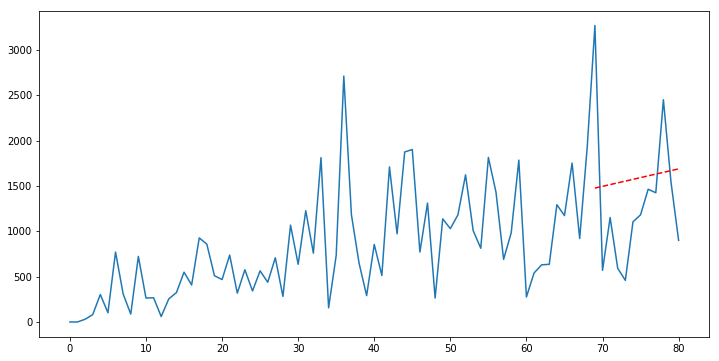

In [26]:
data["Actual 4"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [27]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

73.1

In [29]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 4"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [30]:
round(gmrae(trn1, pred1), 2)

1.16

In [31]:
len(trn1)

12

In [32]:
np.array(trn1)

array([3270,  570, 1152,  591,  459, 1104, 1182, 1464, 1425, 2451, 1542,
        900])

In [33]:
data["Actual 4"][68:80]

68    1941
69    3270
70     570
71    1152
72     591
73     459
74    1104
75    1182
76    1464
77    1425
78    2451
79    1542
Name: Actual 4, dtype: int64

In [34]:
pred1

69    1476.551254
70    1495.831830
71    1515.110934
72    1534.390038
73    1553.669142
74    1572.948247
75    1592.227351
76    1611.506455
77    1630.785559
78    1650.064663
79    1669.343767
80    1688.622871
dtype: float64

In [35]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 4"][68:80])
    return (np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)

In [36]:
round(umbrae(trn1, pred1), 2)

0.52

### DOUBLE Exponentional smoothing Product #1

In [37]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

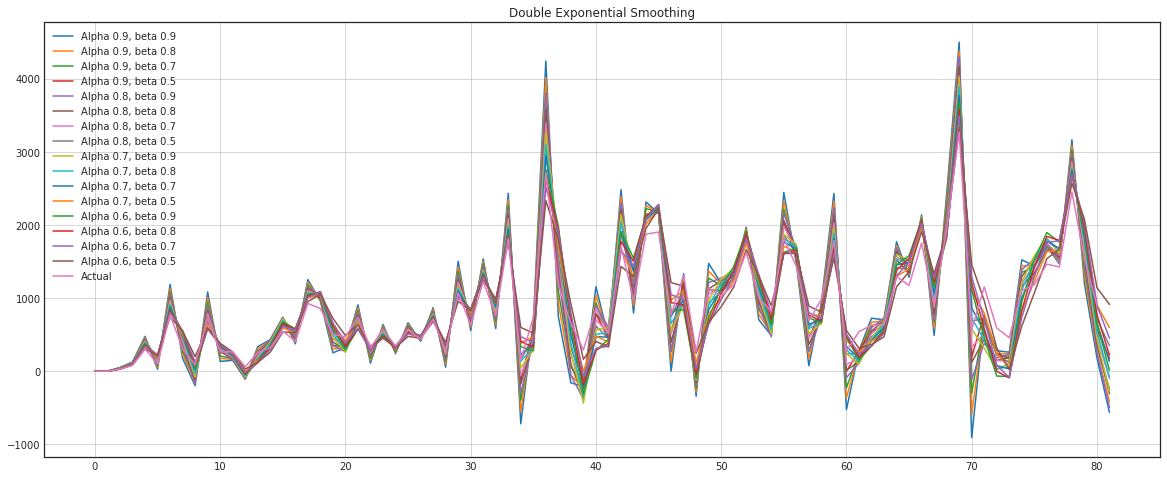

In [38]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 4"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 4"].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [39]:
double_exponential_smoothing(data["Actual 4"],0.9,0.1)[69:81]

[3334.7700509955753,
 796.9160072316156,
 1098.8881622043743,
 578.4754431032565,
 396.88138131385165,
 1022.8626508166647,
 1169.9831391934458,
 1464.9567055037141,
 1455.7579586394065,
 2467.8098676754294,
 1667.5921704882426,
 940.6871054255823]

In [40]:
data["Actual 4"][69:81]

69    3270
70     570
71    1152
72     591
73     459
74    1104
75    1182
76    1464
77    1425
78    2451
79    1542
80     900
Name: Actual 4, dtype: int64

In [41]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 4"][69:81], double_exponential_smoothing(data["Actual 4"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    53.186
0.9    0.8    47.62
0.9    0.7    41.704
0.9    0.6    35.192
0.9    0.5    28.389
0.9    0.4    21.321
0.9    0.3    14.344
0.9    0.2    10.655
0.9    0.1    7.166
0.8    0.9    42.614
0.8    0.8    38.092
0.8    0.7    33.223
0.8    0.6    27.525
0.8    0.5    25.372
0.8    0.4    22.822
0.8    0.3    19.142
0.8    0.2    15.516
0.8    0.1    13.711
0.7    0.9    35.613
0.7    0.8    35.54
0.7    0.7    35.693
0.7    0.6    34.231
0.7    0.5    31.047
0.7    0.4    28.576
0.7    0.3    24.554
0.7    0.2    21.393
0.7    0.1    20.81
0.6    0.9    45.988
0.6    0.8    44.814
0.6    0.7    42.186
0.6    0.6    40.395
0.6    0.5    38.078
0.6    0.4    33.887
0.6    0.3    30.727
0.6    0.2    29.652
0.6    0.1    30.239
0.5    0.9    52.674
0.5    0.8    51.49
0.5    0.7    50.403
0.5    0.6    47.279
0.5    0.5    43.941
0.5    0.4    41.997
0.5    0.3    40.422
0.5    0.2    40.321
0.5    0.1    39.748
0.4    0.9    62.598
0.4    0.8    60.235
0.4    0.7    58.4

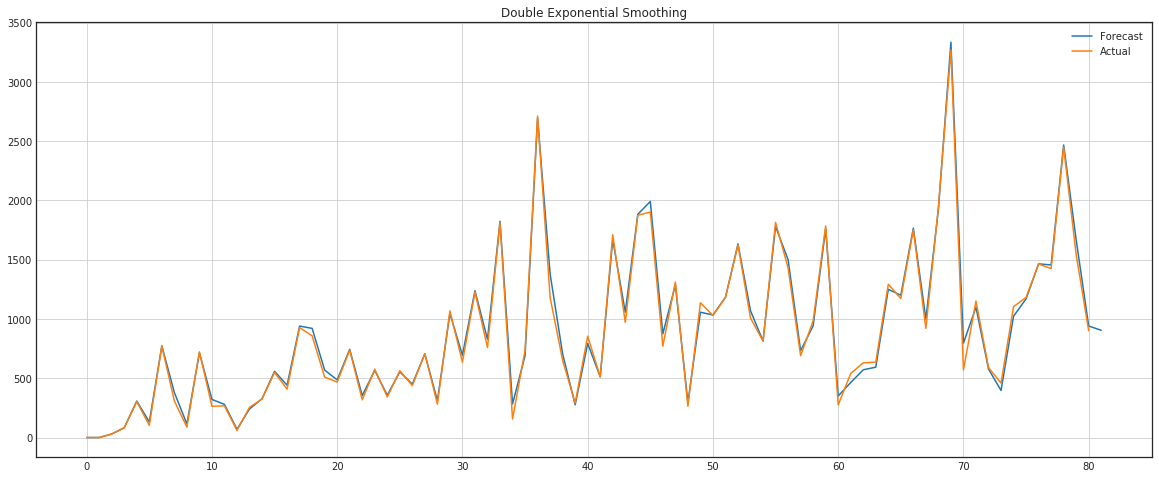

In [42]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 4"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 4"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [43]:
round(mean_absolute_percentage_error(data["Actual 4"][69:81], 
                                     double_exponential_smoothing(data["Actual 3"],0.9,0.1)[69:81]),2)

182.87

In [44]:
round(gmrae(data["Actual 4"][69:81], 
                                     double_exponential_smoothing(data["Actual 4"],0.9,0.1)[69:81]),2)

0.07

In [45]:
round(umbrae(data["Actual 4"][69:81], 
                                     double_exponential_smoothing(data["Actual 4"],0.9,0.1)[69:81]),2)

0.12

## LINEAR REGRESSION

In [46]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 4"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [47]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,303,81.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,102,303.0,81.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,771,102.0,303.0,81.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,309,771.0,102.0,303.0,81.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8,87,309.0,771.0,102.0,303.0,81.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN
9,723,87.0,309.0,771.0,102.0,303.0,81.0,30.0,0.0,0.0,NaN,NaN,NaN


In [48]:
xg=xg.dropna()

In [49]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [51]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [52]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [53]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

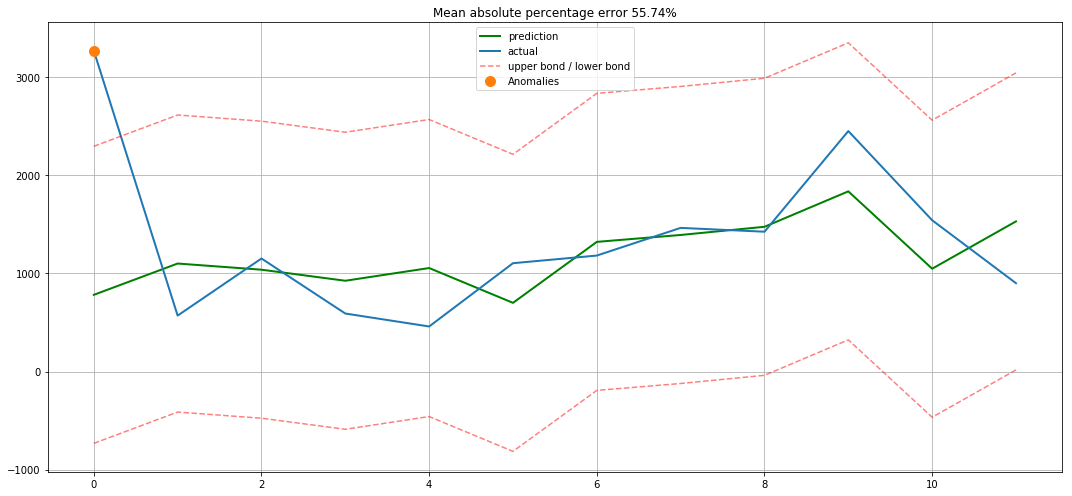

In [54]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [55]:
prediction = lr.predict(X_test)
print (prediction)

[ 781.55071293 1100.68686825 1037.836983    925.1223463  1054.79852101
  699.91568626 1321.3563452  1391.81469126 1475.16011491 1836.360125
 1047.97432514 1530.15823614]


In [56]:
print (y_test)

69    3270
70     570
71    1152
72     591
73     459
74    1104
75    1182
76    1464
77    1425
78    2451
79    1542
80     900
Name: y, dtype: int64


In [57]:
round(mean_absolute_percentage_error(y_test, prediction),2)

45.79

In [58]:
round(gmrae(y_test, prediction), 2)

0.73

In [59]:
round(umbrae(y_test, prediction), 2)

0.43

## XGBOOST 

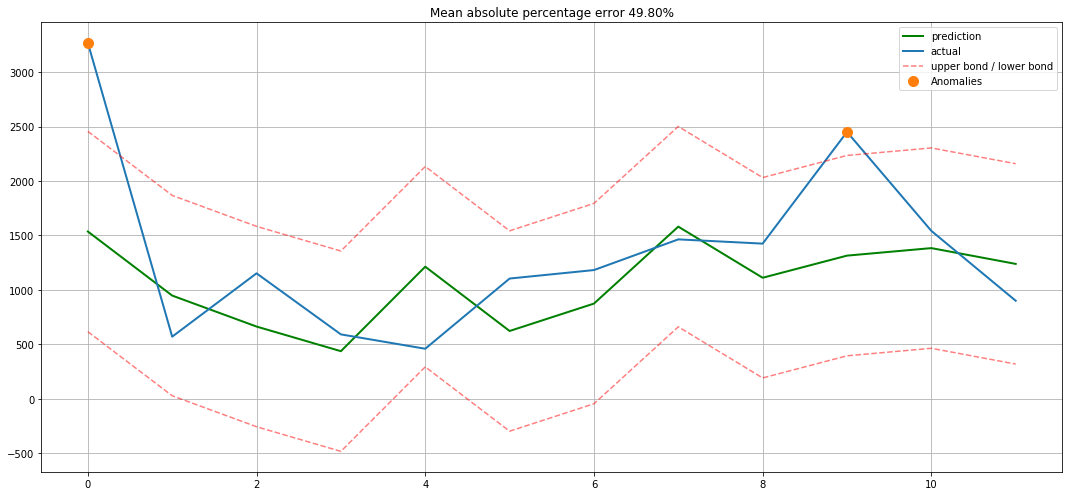

In [60]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [61]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[1536.1936   947.5687   662.95447  436.5426  1213.0304   622.1289
  873.92224 1580.985   1111.2812  1314.6345  1383.7034  1238.6841 ]


In [62]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

45.51

In [63]:
round(gmrae(y_test, prediction1), 2)

0.89

In [64]:
round(umbrae(y_test, prediction1), 2)

0.47

# Facebook Prophet

In [65]:
from fbprophet import Prophet

In [66]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [67]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 4"]})

In [69]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,1752
67,31.05.2017,921
68,30.06.2017,1941


In [70]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,1547.478206,1122.783996,2119.834877,1547.472388,1547.484402,101.513495,101.513495,101.513495,101.513495,101.513495,101.513495,0.0,0.0,0.0,1648.991701
77,2018-03-31,1565.342645,707.601542,1725.587983,1565.335726,1565.350318,-376.913637,-376.913637,-376.913637,-376.913637,-376.913637,-376.913637,0.0,0.0,0.0,1188.429009
78,2018-04-30,1582.630812,1692.859114,2727.266198,1582.622700,1582.639875,609.568349,609.568349,609.568349,609.568349,609.568349,609.568349,0.0,0.0,0.0,2192.199162
79,2018-05-31,1600.495252,530.069004,1563.846715,1600.485740,1600.506079,-567.850404,-567.850404,-567.850404,-567.850404,-567.850404,-567.850404,0.0,0.0,0.0,1032.644848
80,2018-06-30,1617.783419,1749.712925,2800.909018,1617.772564,1617.795474,651.698082,651.698082,651.698082,651.698082,651.698082,651.698082,0.0,0.0,0.0,2269.481501


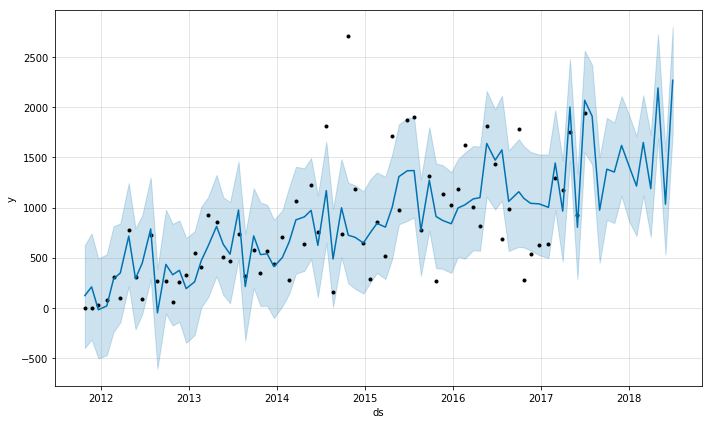

In [72]:
m.plot(forecast);

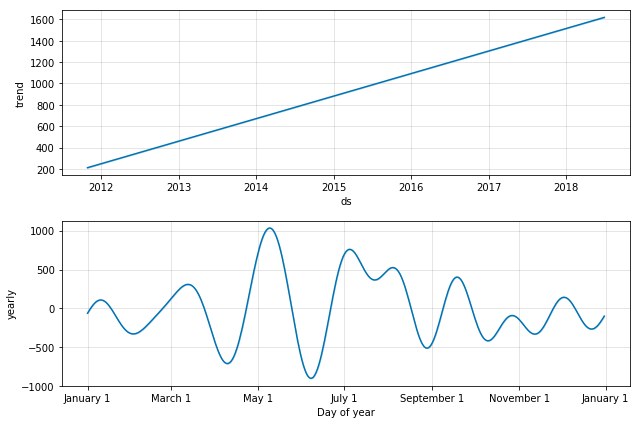

In [73]:
m.plot_components(forecast);

In [74]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [75]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,1648.991701,1122.783996,2119.834877,1464
2018-03-31,1188.429009,707.601542,1725.587983,1425
2018-04-30,2192.199162,1692.859114,2727.266198,2451
2018-05-31,1032.644848,530.069004,1563.846715,1542
2018-06-30,2269.481501,1749.712925,2800.909018,900


In [76]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [77]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 64.18187865597422
MAE 568.2204440451056


In [78]:
cmp_df['y'][-12:]

ds
2017-07-31    3270
2017-08-31     570
2017-09-30    1152
2017-10-31     591
2017-11-30     459
2017-12-31    1104
2018-01-31    1182
2018-02-28    1464
2018-03-31    1425
2018-04-30    2451
2018-05-31    1542
2018-06-30     900
Name: y, dtype: int64

In [79]:
cmp_df['yhat'][-12:]

ds
2017-07-31    1910.718523
2017-08-31     973.815758
2017-09-30    1382.505581
2017-10-31    1354.047910
2017-11-30    1619.574660
2017-12-31    1414.272463
2018-01-31    1213.947296
2018-02-28    1648.991701
2018-03-31    1188.429009
2018-04-30    2192.199162
2018-05-31    1032.644848
2018-06-30    2269.481501
Name: yhat, dtype: float64

In [80]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

64.18

In [81]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.86

In [82]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.46